# Provinding Insurance to Titanic passangers

In this example I try to optimize predictions for precision instead of overall accuracy.
This means I want the model to achieve as much true positives and as few false positives as possible.

Useful articles:
https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

cross validation
https://machinelearningmastery.com/k-fold-cross-validation/

AOC- ROC curve
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

## Data explanation:

PassengerId Unique ID of the passenger

Pclass Passenger's class (1st, 2nd, or 3rd)

Name Passenger's name

Sex Passenger's sex

Age Passenger's age

SibSp Number of siblings/spouses aboard the Titanic

Parch Number of parents/children aboard the Titanic

Ticket Ticket number

Fare Fare paid for ticket

Cabin Cabin number

Embarked Where the passenger got on the ship (C - Cherbourg, S - Southampton, Q = Queenstown)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model,metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import os

for dirname, _, filenames in os.walk('../Classification Data/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../Classification Data/titanic\gender_submission.csv
../Classification Data/titanic\test.csv
../Classification Data/titanic\train.csv


In [2]:
DATA_PATH = '../Classification Data/titanic/'
train_data = pd.read_csv(DATA_PATH + 'train.csv')
test_data = pd.read_csv(DATA_PATH + 'test.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women) / len(women)
print(rate_women)

0.7420382165605095


In [5]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(rate_men)

0.18890814558058924


## Choosing features
I'm going to include numerical and categorical features at first that inuitively make sense: gender, age, class, fare, number of children/parents/siblings/spouses aboard the ship (parch)

In [6]:
features=["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Fare"]
X_train = train_data[features]
y_train = train_data["Survived"]
X_train.head()


,Pclass,Sex,SibSp,Parch,Embarked,Fare
0,3,male,1,0,S,7.2500
1,1,female,1,0,C,71.2833
2,3,female,0,0,S,7.9250
3,1,female,1,0,S,53.1000
4,3,male,0,0,S,8.0500


In [7]:
# Handle missing data:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass      891 non-null int64
Sex         891 non-null object
SibSp       891 non-null int64
Parch       891 non-null int64
Embarked    889 non-null object
Fare        891 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 41.8+ KB


In [8]:
null_columns = X_train.columns[X_train.isnull().any()]
X_train[null_columns].isnull().sum()

print(X_train[X_train["Embarked"].isnull()])
print("-------------------")
print(X_train.loc[61])
print("-------------------")
print(X_train.loc[829])

     Pclass     Sex  SibSp  Parch Embarked  Fare
61        1  female      0      0      NaN  80.0
829       1  female      0      0      NaN  80.0
-------------------
Pclass           1
Sex         female
SibSp            0
Parch            0
Embarked       NaN
Fare            80
Name: 61, dtype: object
-------------------
Pclass           1
Sex         female
SibSp            0
Parch            0
Embarked       NaN
Fare            80
Name: 829, dtype: object


In [9]:
# Separate numerical and categorical features
nums = X_train.select_dtypes('number').columns.values
cats = X_train.select_dtypes('object').columns.values
X_train_num = X_train[nums]
X_train_cat = X_train[cats]

# Scale numeric features
X_train_num = (X_train_num - X_train_num.mean()) / X_train_num.std()
X_train_num = X_train_num.fillna(X_train_num.mean())
X_train_num.head()

,Pclass,SibSp,Parch,Fare
0,0.826913,0.432550,-0.473408,-0.502163
1,-1.565228,0.432550,-0.473408,0.786404
2,0.826913,-0.474279,-0.473408,-0.488580
3,-1.565228,0.432550,-0.473408,0.420494
4,0.826913,-0.474279,-0.473408,-0.486064


In [10]:
#NAN elements are encoded into 0 with get_dummies
X_train_cat = pd.get_dummies(X_train_cat)
X_train_cat.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1


In [11]:
# Combine input into one dataframe
X_train = pd.concat([X_train_num, X_train_cat], axis = 1)
X_train.head()

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.826913,0.432550,-0.473408,-0.502163,0,1,0,0,1
1,-1.565228,0.432550,-0.473408,0.786404,1,0,1,0,0
2,0.826913,-0.474279,-0.473408,-0.488580,1,0,0,0,1
3,-1.565228,0.432550,-0.473408,0.420494,1,0,0,0,1
4,0.826913,-0.474279,-0.473408,-0.486064,0,1,0,0,1


In [12]:
# split into training and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = model_selection.train_test_split(X_train, y_train, random_state=0, test_size = 0.25)

## Use grid search to find best hyperparameters for precision

In [13]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {'min_samples_split': [3,5,10],
             'n_estimators' : [100,200],
             'max_depth': [3,5,15],
             'max_features': [4,6,8]}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [14]:
def grid_search_wrapper(refit_score, param_grid, X_train, y_train, X_valid, y_valid):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit =refit_score, cv = skf)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_valid)
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    # confusion matrix on test data:
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred),
                      columns=['pred_neg','pred_pos'], index=['neg','pos']))
    return grid_search

In [15]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score',
                                     param_grid=param_grid,
                                     X_train = X_train_split,
                                     y_train = y_train_split,
                                     X_valid = X_valid_split,
                                     y_valid = y_valid_split)

C:\Users\Gabor\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params for precision_score
{'max_depth': 3, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       122        17
pos        27        57


In [17]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score',ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
14,0.838,0.620,0.802,3,8,5,100
13,0.838,0.624,0.802,3,8,3,200
25,0.837,0.624,0.804,5,6,3,200
12,0.836,0.620,0.801,3,8,3,100
16,0.834,0.624,0.801,3,8,10,100


## Adjust threshold for precision
Use Precision - Recall curve to visualize tradeoff.

In [18]:
y_scores = grid_search_clf.predict_proba(X_valid_split)[:,1]
p, r, thresholds = precision_recall_curve(y_valid_split, y_scores)



In [26]:
def adjusted_classes(y_scores ,t):
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p,r,thresholds, t=0.5):
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_valid_split, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    plt.figure(figsize=(8,8))
    plt.title("Precision and recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r,p,step='post',alpha=0.2,color='b')
    plt.ylim([0,1.01])
    plt.xlim([0,1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    close_default_clf = np.argmin(np.abs(thresholds - t ))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=15)

     pred_neg  pred_pos
neg       138         1
pos        47        37


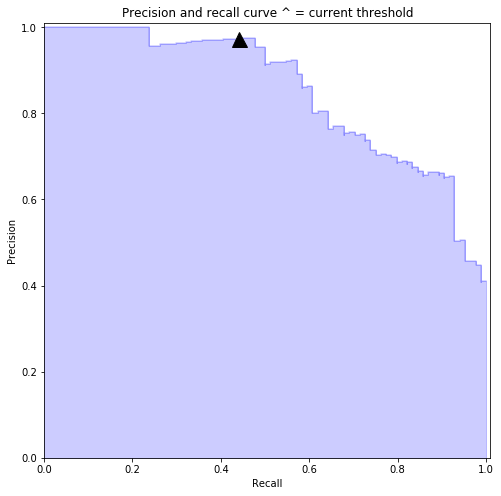

In [30]:
precision_recall_threshold(p,r,thresholds, 0.9)

## ROC Curve

In [32]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    

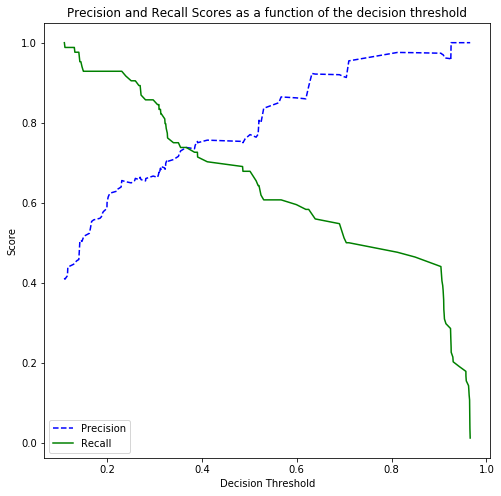

In [33]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.8854059609455293


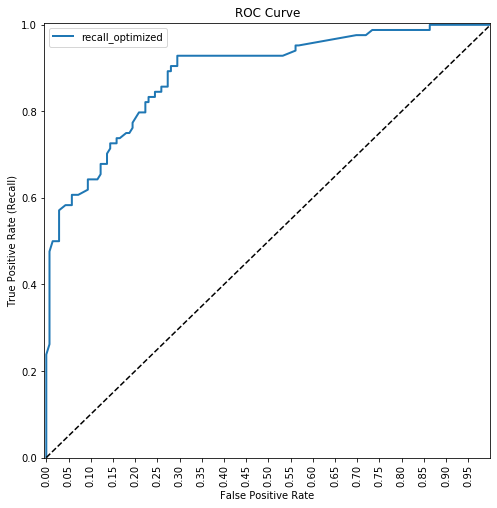

In [37]:
fpr, tpr, auc_thresholds = roc_curve(y_valid_split, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

## Comparing Random Forest and SGD classification


In [55]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model_sgd = linear_model.SGDClassifier(loss='log', max_iter=2000, random_state=0)

In [62]:
model_sgd.fit(X_train_split, y_train_split)
y_pred = model_sgd.predict(X_valid_split)
print("accuracy:")
print(metrics.accuracy_score(y_valid_split,y_pred))
print("f1 score:")
print(metrics.f1_score(y_valid_split, y_pred))
print("precision:")
print(metrics.precision_score(y_valid_split, y_pred))

accuracy:
0.7892376681614349
f1 score:
0.7006369426751592
precision:
0.7534246575342466


In [63]:
model_rf.fit(X_train_split, y_train_split)
y_pred = model_rf.predict(X_valid_split)
print("accuracy:")
print(metrics.accuracy_score(y_valid_split,y_pred))
print("f1 score:")
print(metrics.f1_score(y_valid_split, y_pred))
print("precision:")
print(metrics.precision_score(y_valid_split, y_pred))

accuracy:
0.8071748878923767
f1 score:
0.729559748427673
precision:
0.7733333333333333


In [66]:
# confusion matrix
metrics.confusion_matrix(y_valid_split, y_pred)

array([[122,  17],
       [ 26,  58]], dtype=int64)

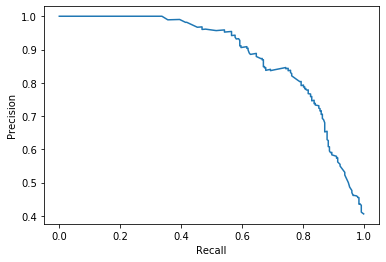

In [67]:
# precision - recall curve
# predict_proba gives actual probabilities not tresholded yet
y_proba_train = model_rf.predict_proba(X_train_split)[:,1]
p, r, t = metrics.precision_recall_curve(y_train_split, y_proba_train)

plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [71]:
X_train_split.shape

(668, 9)

In [77]:
prt = np.array(list(zip(p,r,t)))
prt_df = pd.DataFrame(data=prt, columns=['Precision','Recall','Threshold'])
#only show thresholds where precision is 1 (so the amount of false positives is 0)
prt_df[prt_df['Precision'] == 1]

,Precision,Recall,Threshold
246,1.0,0.337209,0.883528
247,1.0,0.329457,0.889193
248,1.0,0.321705,0.895001
249,1.0,0.317829,0.895366
250,1.0,0.310078,0.898097
251,1.0,0.306202,0.900880
252,1.0,0.302326,0.906897
253,1.0,0.298450,0.907014
254,1.0,0.290698,0.907562
255,1.0,0.286822,0.908715


In [81]:
#seems like 0.883528 is the lowest we can go to not have any false negatives
y_proba_test = model_rf.predict_proba(X_valid_split)[:,1]
y_preds = (y_proba_test >= 0.883528).astype(int)
np.count_nonzero(y_preds)
print("precision:")
print(metrics.precision_score(y_valid_split, y_preds))

precision:
0.9642857142857143


In [ ]:
# so on the test set we aren't reaching 1.0 precision yet

In [87]:
y_proba_test = model_rf.predict_proba(X_valid_split)[:,1]
y_preds = (y_proba_test >= 0.92).astype(int)
print("insurence sold to: ")
print(np.count_nonzero(y_preds))
print("precision:")
print(metrics.precision_score(y_valid_split, y_preds))

insurence sold to: 
19
precision:
1.0


With 0.92 on the validation set we can see we would have sold 19 insurances to survivors and zero to non-survivors.